In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# 超参数
EPOCH = 10
BATCH_SIZE = 64
LR = 0.001
DOWNLOAD_MNIST = False


In [3]:
# CIFAR 10 数据集下载
train_data = datasets.CIFAR10(root=r'./data',
                              train=True,                         # 加载训练集
                              transform=transforms.ToTensor(),    # 将PIL image 或者 numpy.ndarray 转化为 torch.FloatTensor, shape = (C,H,W), 并归一化到 [0, 1]
                              download=True)

test_data = datasets.CIFAR10(root=r'./data',
                             train=False,                         # 加载测试集
                             transform=transforms.ToTensor(),
                             download=True)

Using downloaded and verified file: ./data\cifar-10-python.tar.gz
Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


转置前的矩阵形状：  (3, 32, 32)
转置后的矩阵形状：  (32, 32, 3)


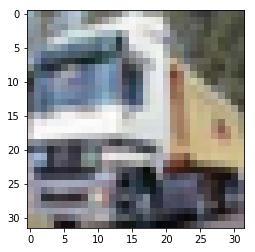

In [4]:
# 输出图像
temp = train_data[1][0].numpy()
print('转置前的矩阵形状： ', temp.shape)

temp = temp.transpose(1, 2, 0)    # 矩阵操作，转置后才可以打印
print('转置后的矩阵形状： ', temp.shape)

# 打印图像
plt.imshow(temp)
plt.show()

In [5]:
# 通过 dataloader 设置分批输入
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True)

# 设置 ResNet Model
model = torchvision.models.resnet50(pretrained=False)
#model = torchvision.models.densenet161(pretrained=False)

# 设置 loss function
criterion = nn.CrossEntropyLoss()

# 设置optimizer
optimizer = optim.Adam(model.parameters(), lr=LR)

# device: set GPU or CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
# 训练
import time
for epoch in range(EPOCH):
    start_time = time.time()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(inputs)
        
        # 计算 loss function
        loss = criterion(outputs, labels)
        
        # 清空梯度
        optimizer.zero_grad()
        
        # 反向传播
        loss.backward()
        
        # 更新参数
        optimizer.step()
    print(f'epoch {epoch+1} loss:{loss.item()} time:{time.time()-start_time}')

# 保存训练的模型
file_name = 'cifar10_resnet.pt'
torch.save(model, file_name)
print(file_name)

epoch 1 loss:1.2723826169967651 time:1094.2003335952759
epoch 2 loss:1.1890177726745605 time:1087.1040635108948
epoch 3 loss:1.8950109481811523 time:1152.3498983383179
epoch 4 loss:1.6173362731933594 time:1132.4801967144012
epoch 5 loss:2.4524128437042236 time:1068.6264486312866
epoch 6 loss:1.2440694570541382 time:1059.104709148407
epoch 7 loss:1.9239343404769897 time:1122.882511138916
epoch 8 loss:1.0376225709915161 time:1080.111575603485
epoch 9 loss:1.6313823461532593 time:1042.8934726715088
epoch 10 loss:0.38714978098869324 time:1278.816447019577
cifar10_resnet.pt


C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BatchNorm2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\ProgramDat

#### 看每个epoch的训练结果的话，RenNet50不是很适合做cifar数据集，应该还是给imageNet比较合适

In [7]:
# test
model = torch.load(file_name)
model.eval()
correct, total = 0, 0

for data in test_loader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    
    # 前向传播
    out = model(images)
    _, predicted = torch.max(out.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    
# 输出识别准确率
print('10000 test images accuracy: {:.4f}%'.format(100.0 * correct/total))

10000 test images accuracy: 65.1300%
